In [199]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [200]:

# Image dimensions and number of classes
img_height, img_width = 128, 128
num_classes = 6  # cardboard, glass, metal, paper, plastic, trash

# Dataset paths
train_dir = r"C:/Users/Begad/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2/processed/train"
val_dir = r"C:/Users/Begad/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2/processed/validation"

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [201]:

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Found 1766 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [202]:

# Compute class weights
y_train = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))


In [203]:

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')


])


In [204]:

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [205]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [206]:

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [207]:

# Train model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stop,lr_scheduler]
)


Epoch 1/30
56/56 [==============================] - 8s 139ms/step - loss: 2.3228 - accuracy: 0.4236 - val_loss: 2.6344 - val_accuracy: 0.1565 - lr: 3.0000e-04
Epoch 2/30
56/56 [==============================] - 6s 114ms/step - loss: 1.3097 - accuracy: 0.5260 - val_loss: 3.2772 - val_accuracy: 0.1910 - lr: 3.0000e-04
Epoch 3/30
56/56 [==============================] - 6s 115ms/step - loss: 1.2428 - accuracy: 0.5510 - val_loss: 2.4634 - val_accuracy: 0.2918 - lr: 3.0000e-04
Epoch 4/30
56/56 [==============================] - 7s 116ms/step - loss: 1.1176 - accuracy: 0.5940 - val_loss: 2.5458 - val_accuracy: 0.2069 - lr: 3.0000e-04
Epoch 5/30
56/56 [==============================] - 7s 116ms/step - loss: 1.0858 - accuracy: 0.6138 - val_loss: 2.3086 - val_accuracy: 0.2812 - lr: 3.0000e-04
Epoch 6/30
56/56 [==============================] - 7s 116ms/step - loss: 1.0627 - accuracy: 0.6166 - val_loss: 1.7551 - val_accuracy: 0.2971 - lr: 3.0000e-04
Epoch 7/30
56/56 [============================

In [ ]:

# Evaluate model
loss, acc = model.evaluate(val_generator)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")


12/12 [==============================] - 0s 33ms/step - loss: 0.6083 - accuracy: 0.8249

✅ Test Accuracy: 82.49%


In [209]:

# Predict and analyze
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


In [ ]:

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(val_generator.class_indices.keys())))



📊 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.92      0.92      0.92        60
       glass       0.82      0.71      0.76        75
       metal       0.84      0.85      0.85        61
       paper       0.84      0.91      0.88        89
     plastic       0.82      0.75      0.78        72
       trash       0.57      0.80      0.67        20

    accuracy                           0.82       377
   macro avg       0.80      0.82      0.81       377
weighted avg       0.83      0.82      0.82       377



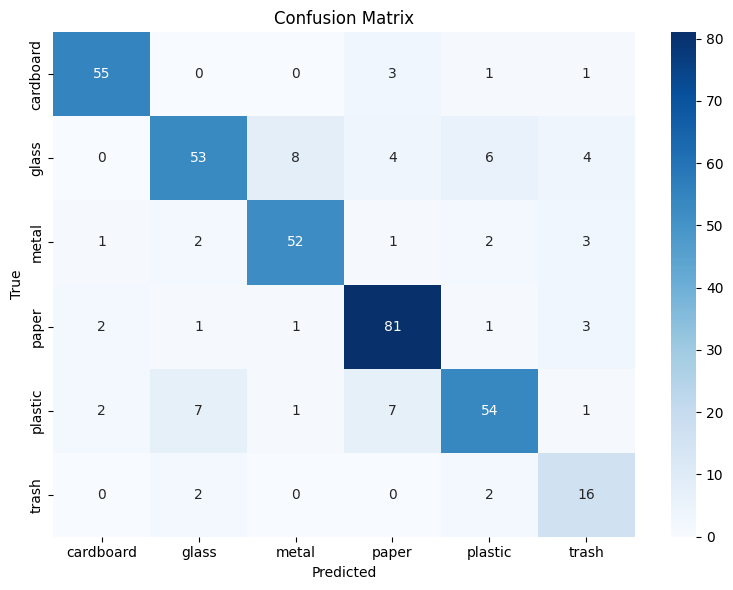

In [211]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()